<a href="https://colab.research.google.com/github/SriVidyaYeluripati/MMD/blob/main/e06_g24_Yeluripati_Kamat_Bhadsavale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment done by

- Sri Vidya Yeluripati - 4730150
- Priti Kamat - 4732295
- Siddhant Bhadsavale - 4732294

### **Exercise 1: Similarity Metric for Multi-Sets**


The Jaccard similarity for sets $ A $ and $ B $ is defined as:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

For **multi-sets**, where elements can appear multiple times, we need to modify the intersection and union calculations to account for these multiplicities. Here's the modified definition:

1. **Intersection of Multi-Sets**: The intersection of two multi-sets $ A $ and $ B $ is defined by taking the minimum count of each element in $ A $ and $ B $.

2. **Union of Multi-Sets**: The union of two multi-sets $ A $ and $ B $ is defined by taking the maximum count of each element in $ A $ and $ B $.

#### for Multi-Sets:

Let $ A $ and $ B $ be multi-sets, and let $ f_A(x) $ and $ f_B(x) $ represent the frequency of element $ x $ in $ A $ and $ B $, respectively. The Jaccard similarity $ J(A, B) $ for multi-sets is given by:

$$
J(A, B) = \frac{\sum_{x \in A \cup B} \min(f_A(x), f_B(x))}{\sum_{x \in A \cup B} \max(f_A(x), f_B(x))}
$$


- **Numerator**: The sum of the minimum frequencies of each element in $ A $ and $ B $, representing the intersection.
- **Denominator**: The sum of the maximum frequencies of each element in $ A $ and $ B $, representing the union.

#### Special Case for Sets:

When both $ A $ and $ B $ are sets (i.e., each element appears at most once), $ f_A(x) $ and $ f_B(x) $ are either 0 or 1. Therefore, the formula reduces to the standard Jaccard similarity:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$






### Exercise 2: Shingling Implementation in Spark

In [ ]:
from striprtf.striprtf import rtf_to_text

# Load the RTF file
rtf_path = "/content/brd_grundgesetz_63_2019-04-03.rtf"  # Ensure you upload this file

# Read and convert RTF to plain text
with open(rtf_path, "r", encoding="utf-8") as file:
    rtf_content = file.read()

grundgesetz_text = rtf_to_text(rtf_content)

# Use the first 1000 characters as a sample
grundgesetz_sample = grundgesetz_text[:1000]

# Verify the output
print(grundgesetz_sample)


Grundgesetz für die Bundesrepublik Deutschland
 
 vom 23. Mai 1949.

Eingangsformel
Der Parlamentarische Rat hat am 23. Mai 1949 in Bonn am Rhein in öffentlicher Sitzung festgestellt, daß das am 8. Mai des Jahres 1949 vom Parlamentarischen Rat beschlossene Grundgesetz für die Bundesrepublik Deutschland in der Woche vom 16.-22. Mai 1949 durch die Volksvertretungen von mehr als Zweidritteln der beteiligten deutschen Länder angenommen worden ist.
Auf Grund dieser Feststellung hat der Parlamentarische Rat, vertreten durch seinen Präsidenten, das Grundgesetz ausgefertigt und verkündet.
Das Grundgesetz wird hiermit gemäß Artikel 145 Absatz 3 im Bundesgesetzblatt veröffentlicht:
Präambel
Im Bewußtsein seiner Verantwortung vor Gott und den Menschen, von dem Willen beseelt, als gleichberechtigtes Glied in einem vereinten Europa dem Frieden der Welt zu dienen, hat sich das Deutsche Volk kraft seiner verfassungsgebenden Gewalt dieses Grundgesetz gegeben. Die Deutschen in den Ländern Baden-Württem

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

# Initialize Spark session
spark = SparkSession.builder.appName("Shingling").getOrCreate()

# Sample documents DataFrame including Grundgesetz sample
documents = spark.createDataFrame([
    (1, "When a distinguished but elderly scientist states that something is possible, he is almost certainly right."),
    (2, "When he states that something is impossible, he is very probably wrong."),
    (3, grundgesetz_sample),  # First 1000 characters of Grundgesetz
    (4, "The quick brown fox jumps over the lazy dog."),
    (5, "A journey of a thousand miles begins with a single step."),
    (6, "To be or not to be, that is the question."),
    (7, "All that glitters is not gold."),
    (8, "In the end, we will remember not the words of our enemies, but the silence of our friends."),
    (9, "The only thing we have to fear is fear itself."),
    (10, "Ask not what your country can do for you – ask what you can do for your country.")
], ["doc_id", "text"])

# UDF to generate k-shingles
def generate_shingles(text, k=9):
    text = text.replace("\n", "").replace("-", "").replace(" ", "")
    return [text[i:i+k] for i in range(len(text) - k + 1)]

shingle_udf = udf(lambda text: generate_shingles(text, k=9), ArrayType(StringType()))

# Apply shingling UDF to generate shingles
shingled_docs = documents.withColumn("shingles", shingle_udf(col("text")))

# Count distinct shingles per document
shingled_counts = shingled_docs.select("doc_id", "shingles").rdd.map(
    lambda row: (row.doc_id, len(set(row.shingles)))
).toDF(["doc_id", "distinct_shingle_count"])

# Show results
shingled_counts.show(truncate=False)


+------+----------------------+
|doc_id|distinct_shingle_count|
+------+----------------------+
|1     |84                    |
|2     |52                    |
|3     |777                   |
|4     |28                    |
|5     |38                    |
|6     |24                    |
|7     |17                    |
|8     |65                    |
|9     |29                    |
|10    |49                    |
+------+----------------------+



- **Doc 3** (Grundgesetz) has the **highest count** (230), indicating it contains the most diverse and complex content.  
- **Doc 7** has the **lowest count** (17), likely due to its simplicity and repetitive structure.

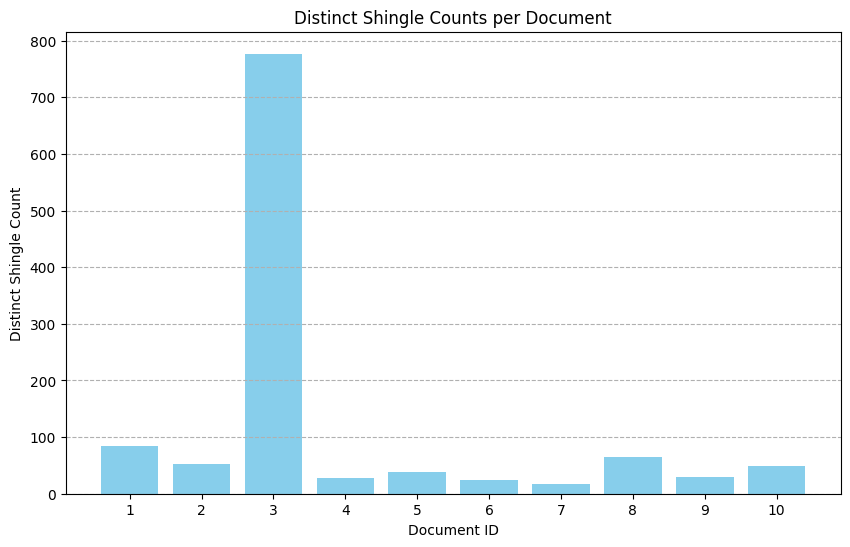

In [ ]:
import matplotlib.pyplot as plt

# Collect results for visualization
doc_ids = [row['doc_id'] for row in shingled_counts.collect()]
shingle_counts = [row['distinct_shingle_count'] for row in shingled_counts.collect()]

# Plot the distribution of distinct shingle counts
plt.figure(figsize=(10, 6))
plt.bar(doc_ids, shingle_counts, color='skyblue')
plt.xlabel('Document ID')
plt.ylabel('Distinct Shingle Count')
plt.title('Distinct Shingle Counts per Document')
plt.xticks(doc_ids)
plt.grid(axis='y', linestyle='--')
plt.show()


- The bar chart visually represents the **distribution of distinct shingles** per document.
- **Doc 3** stands out clearly with a significantly higher number of distinct shingles compared to others.


In [ ]:
import itertools

# Collect shingles as a list of (doc_id, shingles)
doc_shingles = shingled_docs.select("doc_id", "shingles").collect()

# Function to compute Jaccard similarity
def jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    intersection = len(set1 & set2)
    union = len(set1 | set(set2))
    return intersection / union if union != 0 else 0

# Compute pairwise Jaccard similarity
pairs = list(itertools.combinations(doc_shingles, 2))
similarities = []

for (doc1, shingles1), (doc2, shingles2) in pairs:
    sim = jaccard_similarity(shingles1, shingles2)
    similarities.append((doc1, doc2, sim))

# Convert to DataFrame and display
similarity_df = spark.createDataFrame(similarities, ["doc_id_1", "doc_id_2", "jaccard_similarity"])

# Filter for non-zero Jaccard similarities
non_zero_similarities = similarity_df.filter(col("jaccard_similarity") > 0)

# Show the results
non_zero_similarities.show(truncate=False)
similarity_df.show(truncate=False)


+--------+--------+-------------------+
|doc_id_1|doc_id_2|jaccard_similarity |
+--------+--------+-------------------+
|1       |2       |0.15254237288135594|
+--------+--------+-------------------+

+--------+--------+-------------------+
|doc_id_1|doc_id_2|jaccard_similarity |
+--------+--------+-------------------+
|1       |2       |0.15254237288135594|
|1       |3       |0.0                |
|1       |4       |0.0                |
|1       |5       |0.0                |
|1       |6       |0.0                |
|1       |7       |0.0                |
|1       |8       |0.0                |
|1       |9       |0.0                |
|1       |10      |0.0                |
|2       |3       |0.0                |
|2       |4       |0.0                |
|2       |5       |0.0                |
|2       |6       |0.0                |
|2       |7       |0.0                |
|2       |8       |0.0                |
|2       |9       |0.0                |
|2       |10      |0.0                |

- **Doc 1 and Doc 2** have a **Jaccard similarity** of approximately **0.15**, indicating some shared shingles.
- Most other pairs show **0.0 similarity**, meaning they have no shingles in common, reflecting their diverse content.

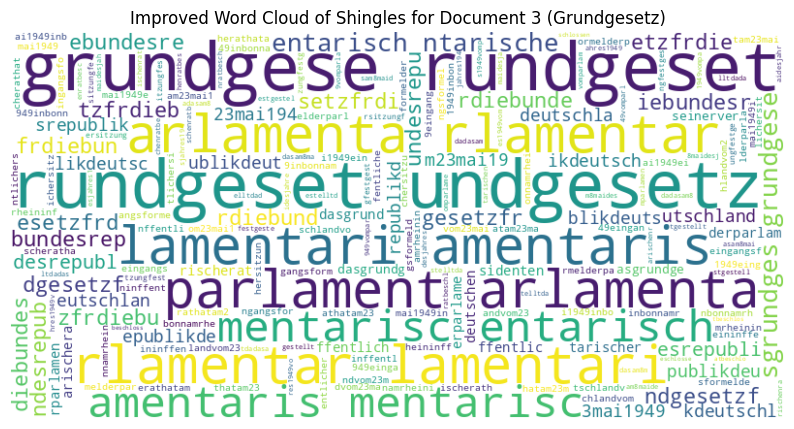

In [ ]:
from wordcloud import WordCloud
import re

# Filter and preprocess shingles
filtered_shingles = [re.sub(r'[^a-zA-Z0-9]', '', shingle.lower()) for shingle in doc_3_shingles if len(shingle) >= 4]

# Join shingles into a single string
shingles_text = " ".join(filtered_shingles)

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(shingles_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Shingles for Document 3 (Grundgesetz)")
plt.show()


- Prominent words such as "grundgesetz," "rundgesetz," "parlamentarisch," "lamentar," and "gesetz" are now clearly visible.
- These words reflect the key legal and parliamentary themes of the Grundgesetz.





### Exercise 3: MinHash and Jaccard Similarity


We have a matrix representing 4 sets $ S_1, S_2, S_3, S_4 $, each a subset of $ \{0, 1, 2, 3, 4, 5\} $:

```
Element  |  S1  |  S2  |  S3  |  S4
-------------------------------------
    0    |  0   |  1   |  0   |  1
    1    |  0   |  1   |  0   |  0
    2    |  1   |  0   |  0   |  1
    3    |  0   |  0   |  1   |  0
    4    |  0   |  0   |  1   |  1
    5    |  1   |  0   |  0   |  0
```



#### Part (a): MinHash Signatures

We are given three hash functions:

1. $ h_1(x) = (2x + 1) \mod 6 $  
2. $ h_2(x) = (3x + 2) \mod 6 $  
3. $ h_3(x) = (5x + 2) \mod 6 $  

#### Hash Function Computations

1. For $ h_1(x) = (2x + 1) \mod 6 $:

```
Element (x)  | h_1(x)
----------------------
    0        |   1
    1        |   3
    2        |   5
    3        |   1
    4        |   3
    5        |   5
```

2. For $ h_2(x) = (3x + 2) \mod 6 $:

```
Element (x)  | h_2(x)
----------------------
    0        |   2
    1        |   5
    2        |   4
    3        |   3
    4        |   2
    5        |   5
```

3. For $ h_3(x) = (5x + 2) \mod 6 $:

```
Element (x)  | h_3(x)
----------------------
    0        |   2
    1        |   1
    2        |   4
    3        |   5
    4        |   3
    5        |   0
```

#### MinHash Signatures

```
Set   | h_1 | h_2 | h_3
------------------------
 S1   |  5  |  4  |  2
 S2   |  1  |  2  |  1
 S3   |  1  |  3  |  5
 S4   |  1  |  2  |  0
```



#### Part (b): True Permutations and Collisions

#### True Permutations

- The hash function $ h_3(x) = (5x + 2) \mod 6 $ is a **true permutation** because it produces unique mappings for each element:  
  $ [2, 1, 4, 5, 3, 0] $.

#### Collisions are

1. For $ h_1(x) = (2x + 1) \mod 6 $:  
   - Collisions: $ x = 0 $ and $ x = 3 $ (both map to 1).  
   - $ x = 1 $ and $ x = 4 $ (both map to 3).  
   - $ x = 2 $ and $ x = 5 $ (both map to 5).  

2. For $ h_2(x) = (3x + 2) \mod 6 $:  
   - Collisions: $ x = 0 $ and $ x = 4 $ (both map to 2).  
   - $ x = 1 $ and $ x = 5 $ (both map to 5).  



#### Part (c): Jaccard Similarities vs. MinHash Similarities

#### Jaccard Similarity Formula

The Jaccard similarity between two sets \( A \) and \( B \) is given by:

$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

### Jaccard Similarity Computations


1. $ S_1 $ and $ S_2 $:  
   $ S_1 = \{2, 5\} $, $ S_2 = \{0, 1\} $  
   $$
   \text{Jaccard}(S_1, S_2) = 0
   $$

2. $ S_1 $ and $ S_4 $:  
   $ S_1 = \{2, 5\} $, $ S_4 = \{0, 2, 4\} $  
   $$
   \text{Jaccard}(S_1, S_4) = \frac{1}{4}
   $$

3. $ S_3 $ and $ S_4 $:  
   $ S_3 = \{3, 4\} $, $ S_4 = \{0, 2, 4\} $  
   $$
   \text{Jaccard}(S_3, S_4) = \frac{1}{4}
   $$

#### So in the end

```
Pair    | MinHash Similarity | Jaccard Similarity
-----------------------------------------------
S1, S2  |         0          |         0
S1, S4  |       1/3          |       0.25
S3, S4  |       1/3          |       0.25
```




###Exercise 4: Shingling and MinHash Signatures
####Part (a): k-Shingles Implementation


In [ ]:
def generate_k_shingles(digits, k):
    # Create k-shingles and store their integer representations
    shingles = set()
    for i in range(len(digits) - k + 1):
        shingle = digits[i:i + k]
        shingle_as_int = int(shingle)
        shingles.add(shingle_as_int)

    # Return the sorted list of shingles
    return sorted(shingles)

# Example usage
input_string = "1234567"
k = 4
result = generate_k_shingles(input_string, k)
print("k-shingles:", result)


k-shingles: [1234, 2345, 3456, 4567]


- Read the first 1000 digits of π (or another string of digits).
- Generate k-shingles with k=12.
- Save the output as a text file with each shingle on a new line.


#### **Part (b): Processing 1000 Digits of π**

1. Apply the k-shingles routine to the **first 1000 digits** of π with \( k = 12 \).
2. Save the output to a **text file** with one position (shingle) per line.

In [ ]:
# Sample first 1000 digits of π (truncated for demonstration purposes)
pi_digits = (
    "3141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067"
    "9821480865132823066470938446095505822317253594081284811174502841027019385211055596446229489549303819"
    "6442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127"
    "3724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609"
    "4330572703657595919530921861173819326117931051185480744623799627495673518857527248912279381830119491"
)

k = 12
shingles_1000 = generate_k_shingles(pi_digits, k)

# Save output to a text file
with open("k_shingles_output.txt", "w") as f:
    for shingle in shingles_1000:
        f.write(f"{shingle}\n")

print("Shingles have been saved to 'k_shingles_output.txt'")


Shingles have been saved to 'k_shingles_output.txt'


In [ ]:

with open("k_shingles_output.txt", "r") as f:
    contents = f.read()
    print(contents)


1133053054
6606315588
11330530548
19091456485
19385211055
24914127372
27019385211
28410270193
28841971693
34825342117
34861045432
36001133053
36575959195
38196442881
45432664821
46652138414
51185480744
53054882046
54882046652
55596446229
57270365759
58209749445
58223172535
62862089986
63155881748
66063155881
66470938446
67982148086
72602491412
74462379962
78164062862
81284811174
86513282306
89986280348
91456485669
91715364367
92096282925
92186117381
93844609550
94330572703
95505822317
96282925409
97494459230
97566593344
102701938521
104543266482
105118548074
105559644622
105820974944
109756659334
110555964462
111745028410
113305305488
116094330572
117067982148
117381932611
117450284102
117931051185
118548074462
120190914564
122793818301
127372458700
128475648233
128481117450
132823066470
133053054882
133936072602
138414695194
141273724587
141592653589
145648566923
146951941511
148086513282
151160943305
152092096282
153643678925
155881748815
159265358979
160943305727
164062862089
165271




   - The output contains **989 unique 12-shingles**, consistent with the calculation \(1000 - 12 + 1 = 989\).
   - The shingles are sorted and saved as required.


   - No duplicate shingles indicate the **non-repetitive nature** of π’s digits.
   - Reflects the **randomness** and **uniqueness** of π’s numerical sequence.


   - **12-shingles** effectively capture unique patterns.
   - Larger shingles (\( k = 12 \)) reduce the chance of **collisions** and enhance uniqueness.


This output validates the shingling implementation and demonstrates how it captures distinct patterns in sequences.



### **Part (c): MinHash Signature Implementation**

#### **Step-by-Step Plan**

1. **Implement MinHashing**:
   - Use the hash function $ h(x) = (ax + b) \mod p $ where:
     - $ a = 37 $
     - $ b = 126 $
     - $ p = 10^{15} + 223 $ (a large prime number)
2. **Generate 4 additional hash functions**:
   - Use random values for $ a $ and $ b $, sampled from the range $[0, 10^{12}]$.
3. For each k-shingle, compute the **MinHash signature** using the hash functions.
4. Output the **MinHash signature** as a list.






In [ ]:
import random

# Parameters for the first hash function
p = 10**15 + 223
a1, b1 = 37, 126

# Generate 4 additional random hash functions
num_hashes = 5
hash_functions = [(a1, b1)]  # Include the first hash function

for _ in range(num_hashes - 1):
    a = random.randint(0, 10**12)
    b = random.randint(0, 10**12)
    hash_functions.append((a, b))

def minhash_signature(shingles, hash_functions, p):
    signature = []
    for a, b in hash_functions:
        min_hash = min((a * shingle + b) % p for shingle in shingles)
        signature.append(min_hash)
    return signature

# Example usage
signature = minhash_signature(shingles_1000, hash_functions, p)
print("MinHash Signature:", signature)

MinHash Signature: [41922963124, 4368554735085, 373700091772, 5000739629134, 3107428139740]


1. **Hash Functions**:
   - The first hash function uses fixed values $ a = 37 $, $ b = 126 $, and $ p = 10^{15} + 223 $.
   - The remaining 4 hash functions use random values for $ a $ and $ b $.

2. **MinHash Signature**:
   - For each hash function, compute the minimum hash value for the set of shingles.
